# Bayesian Rule Extraction to Explain Income from Census Data

This demonstrates the Gopalakrishnan "*Bayesian Rule Extraction*" algorithm applied on the more-realistic *Adult* dataset, which is a common dataset when benchmarking *interpretable* or *fair* methods (some of my setup here is adapted from the [InterpretML documentation for the Explainable Boosting Machine](https://interpret.ml/docs/ebm.html) (used under terms of the *MIT License*)).

This follows the standard binary classification problem where the goal is to predict whether a person made more/less than $50,000 using attributes like "Age," "Education," "MaritalStatus," etc.

In [ ]:
# If you're running in colab, run this cell for setup.
! apt install libgraphviz-dev
! pip install pomegranate numpy pandas matplotlib pygraphviz
! pip install git+https://github.com/hayesall/bn-rule-extraction.git

In [1]:
from bayes_rule_extraction import ordinal_encode, print_rules
from pomegranate import BayesianNetwork
import pandas as pd

## Some data normalizing

`pomegranate` supports structure learning for discrete Bayesian Networks, so for now we'll:

1. Drop continuous-valued attributes (we could have binned them).
2. Replace with a standard `NaN` value and drop rows where these occur.

In [2]:
data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None
)
data.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

data.drop(["Age", "fnlwgt", "EducationNum", "CapitalGain", "CapitalLoss", "HoursPerWeek"], axis=1, inplace=True)
data.replace(" ?", pd.NA, inplace=True)
data.dropna(inplace=True)

data

,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry,Income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K


`bayes-rule-extraction` includes an `ordinal_encode` helper function that takes an array/dataframe and produces an ordinal-encoded version of the data, and a `mapping` used to produce human-readable IF/THEN rules.

In [3]:
encoded, mapping = ordinal_encode(data.columns, data)

encoded

array([[ 5.,  9.,  4., ...,  1., 38.,  0.],
       [ 4.,  9.,  2., ...,  1., 38.,  0.],
       [ 2., 11.,  0., ...,  1., 38.,  0.],
       ...,
       [ 2., 11.,  6., ...,  0., 38.,  0.],
       [ 2., 11.,  4., ...,  1., 38.,  0.],
       [ 3., 11.,  2., ...,  0., 38.,  1.]], dtype=float32)

*Gopalakrishnan 2010* used a modified version of the K2 structure learning algorithm. This uses pomegranate's `.from_samples` method to fitting exact structures using search.

K2 would have provided some control over the maximum number of edges and whether one node can be the parent of another through a user's choice of variable ordering. Similar to what I showed in the "Tennis" example, some advice to constrain variable parentage is probably useful in practice.

For example, leaving the model "unconstrained" may produce network structures and downstream rules that are more difficult to interpret:

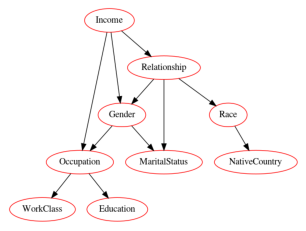

In [4]:
unconstrained_model = BayesianNetwork().from_samples(
    encoded,
    algorithm="exact",
    state_names=data.columns,
    max_parents=-1,
)

unconstrained_model.plot()

Similar to the Naive Bayes case from the "Tennis" example, you might be able to make guesses when knowing the prior probabilities of the outcomes and its influence on other variables. But "Income" was what we wanted to predict, and a network rooted at "Income" means that it will never occur after a `THEN`.

In [5]:
print_rules(unconstrained_model, data.columns, mapping)

Probabilities:
- Income
  P( Income =  <=50K ) = 0.75
  P( Income =  >50K ) = 0.25

IF (Occupation =  Adm-clerical) THEN (WorkClass =  Private)
	CF = 3.01
IF (Occupation =  Armed-Forces) THEN (WorkClass =  Federal-gov)
	CF = inf
IF (Occupation =  Craft-repair) THEN (WorkClass =  Private)
	CF = 3.56
IF (Occupation =  Exec-managerial) THEN (WorkClass =  Private)
	CF = 1.97
IF (Occupation =  Handlers-cleaners) THEN (WorkClass =  Private)
	CF = 13.21
IF (Occupation =  Machine-op-inspct) THEN (WorkClass =  Private)
	CF = 22.40
IF (Occupation =  Other-service) THEN (WorkClass =  Private)
	CF = 4.87
IF (Occupation =  Priv-house-serv) THEN (WorkClass =  Private)
	CF = inf
IF (Occupation =  Prof-specialty) THEN (WorkClass =  Private)
	CF = 1.26
IF (Occupation =  Sales) THEN (WorkClass =  Private)
	CF = 4.20
IF (Occupation =  Tech-support) THEN (WorkClass =  Private)
	CF = 3.83
IF (Occupation =  Transport-moving) THEN (WorkClass =  Private)
	CF = 3.84
IF (Occupation =  Machine-op-inspct) THEN (E

/home/hayesall/Classes/bn-rule-extraction/bayes_rule_extraction/bayes_rule_extraction.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  _conf_factor = row[-1] / (1 - row[-1])


`pomegranate` provides some control over variable influences using the `include_edges` or `exclude_edges` parameters in the `.from_samples` method.

Since we're interested in "Income," this adds a constraint requiring: "*Income cannot be the parent of any node.*"

This tends to produce a network rooted at "MaritalStatus," with "Income" having "Relationship" and "Education" as parents.

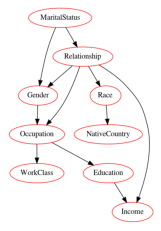

In [6]:
excluded_edges = [tuple([8, i]) for i in range(len(data.columns)-1)]

model = BayesianNetwork().from_samples(
    encoded,
    algorithm="exact",
    exclude_edges=excluded_edges,
    state_names=data.columns,
    max_parents=-1,
)

model.plot()

There are a lot of rules with rules with confidence between `1.0 - inf`:

In [7]:
print_rules(model, data.columns, mapping)

Probabilities:
- MaritalStatus
  P( MaritalStatus =  Divorced ) = 0.14
  P( MaritalStatus =  Married-AF-spouse ) = 0.00
  P( MaritalStatus =  Married-civ-spouse ) = 0.47
  P( MaritalStatus =  Married-spouse-absent ) = 0.01
  P( MaritalStatus =  Never-married ) = 0.32
  P( MaritalStatus =  Separated ) = 0.03
  P( MaritalStatus =  Widowed ) = 0.03

IF (Occupation =  Adm-clerical) THEN (WorkClass =  Private)
	CF = 3.01
IF (Occupation =  Armed-Forces) THEN (WorkClass =  Federal-gov)
	CF = inf
IF (Occupation =  Craft-repair) THEN (WorkClass =  Private)
	CF = 3.56
IF (Occupation =  Exec-managerial) THEN (WorkClass =  Private)
	CF = 1.97
IF (Occupation =  Handlers-cleaners) THEN (WorkClass =  Private)
	CF = 13.21
IF (Occupation =  Machine-op-inspct) THEN (WorkClass =  Private)
	CF = 22.40
IF (Occupation =  Other-service) THEN (WorkClass =  Private)
	CF = 4.87
IF (Occupation =  Priv-house-serv) THEN (WorkClass =  Private)
	CF = inf
IF (Occupation =  Prof-specialty) THEN (WorkClass =  Private)
